# Outbrain advertisement click prediction
by Ryan Goy, https://www.linkedin.com/in/goyryan

useful links:
 - [10 minutes to pandas](http://pandas.pydata.org/pandas-docs/version/0.15.2/10min.html)
 - [EDA graphs](https://www.kaggle.com/anokas/outbrain-click-prediction/outbrain-eda)

In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import csv
import gc

%matplotlib inline

### Import Datasets

We'll start with importing the minimum amount of data in order to get a MVP for now and add more feature later when we're on the scoreboard. 

 - click_train and clicks_test both have a display_id (the unique context it was displayed in) and an ad_id (the id of an ad it was)
 - events has information correlating to each display_id
 - promoted_content has information correlating to each ad_id
 - documents_meta has information elaborating on the document the ad links (nested in promoted_content)
 - page_views is the huge dataset with information about the type of people who visit the linked ads
 - documents_topics, documents_entities, and documents_categories all provide information about the content in the ad
 
Thus, the possible characteristics we can train on are the following:

 - events: document_id, timestamp, platform, geo_location
 - promoted_content: document_id, campaign_id, advertiser_id
 - etc (will deal with other sets later)
 
For now, I'm only using click_train, clicks_test, events, and promoted_content

In [2]:
clicks_train = pd.read_csv('../data/clicks_train.csv')
clicks_test = pd.read_csv('../data/clicks_test.csv')

In [3]:
print clicks_train.shape
print clicks_test.shape

(87141731, 3)
(32225162, 2)


In [4]:
events = pd.read_csv('../data/events.csv')
promoted_content = pd.read_csv('../data/promoted_content.csv')
documents_metadata = pd.read_csv('../data/documents_meta.csv')
documents_topics = pd.read_csv('../data/documents_topics.csv')
documents_entities = pd.read_csv('../data/documents_entities.csv')
documents_categories = pd.read_csv('../data/documents_categories.csv')

/home/ryan/Libraries/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### View/investigate datasets

also see [this](https://www.kaggle.com/anokas/outbrain-click-prediction/outbrain-eda) for graphs

In [5]:
clicks_train.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [6]:
print clicks_train.shape

(87141731, 3)


In [7]:
clicks_test.head()

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


In [8]:
print clicks_test.shape

(32225162, 2)


In [9]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [10]:
promoted_content.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


In [11]:
print promoted_content.shape

(559583, 4)


In [12]:
documents_metadata.head()

,document_id,source_id,publisher_id,publish_time
0,1595802,1.0,603.0,2016-06-05 00:00:00
1,1524246,1.0,603.0,2016-05-26 11:00:00
2,1617787,1.0,603.0,2016-05-27 00:00:00
3,1615583,1.0,603.0,2016-06-07 00:00:00
4,1615460,1.0,603.0,2016-06-20 00:00:00


In [13]:
documents_entities.head()

,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399114
2,1524246,839907a972930b17b125eb0247898412,0.392096
3,1524246,04d8f9a1ad48f126d5806a9236872604,0.213996
4,1617787,612a1d17685a498aff4f036c1ee02c16,0.386193


In [14]:
documents_categories.head()

,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92
3,1524246,1608,0.07
4,1617787,1807,0.92


In [15]:
documents_topics.head()

,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


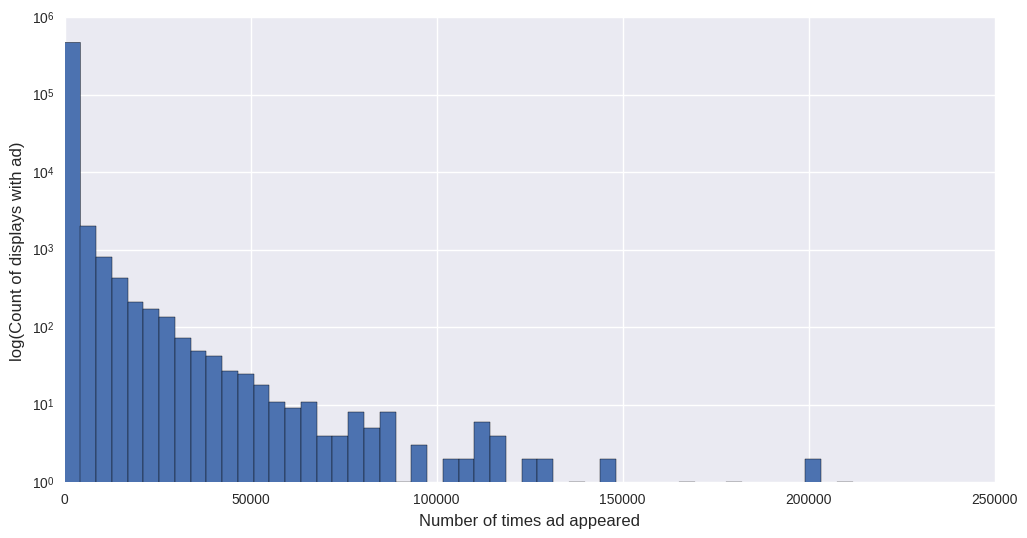

In [16]:
ad_usage_train = clicks_train.groupby('ad_id')['ad_id'].count()

for i in [2, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

In [17]:
documents_categories.groupby('document_id')

In [18]:
L = ['A','A','B','B','B','C']
N = [1,2,5,5,4,6]
P = [1, 2, 1, 2, 3, 1]
mf = pd.DataFrame(zip(L,N,P),columns = list('LNP'))
groups = mf.iloc[mf.groupby(mf.L).apply(lambda x: x['P'].idxmax())]

In [19]:
groups

,L,N,P
1,A,2,2
4,B,4,3
5,C,6,1


In [20]:
dc = documents_categories.iloc[documents_categories.groupby('document_id').apply(lambda x: x['document_id'].idxmax())]

### Format and load training data
each click has document_from, timestamp, platform, geo_location, document_to, campaign_id, advertiser_id (so far)

In [21]:
# ad_id, document_from, timestamp, platform, geo_location, document_to, campaign_id, advertiser_id

def load_raw_joined_train_df():
    
    # join clicks_train, events, and promoted_content
    ads_info = promoted_content.merge(documents_metadata, on='document_id', how='inner')
    #dc = documents_categories.iloc[documents_categories.groupby('document_id').apply(lambda x: x['document_id'].idxmax())]
    #ads_info = ads_info.merge(documents_topics, on='document_id', how='inner')
    ads_info = ads_info.merge(dc, on='document_id', how='left')
    #ads_info = ads_info.drop('document_id', 1)
    
    combined = clicks_train.merge(events, on='display_id', how='inner')
    combined = combined.drop('document_id', 1)
    #combined = combined.drop('display_id', 1)
    combined = combined.drop('uuid', 1)
    
    combined = combined.merge(ads_info, on='ad_id', how='inner', suffixes=('_from', '_to'))
    #combined = combined.drop('ad_id', 1)

    combined = combined.sort_values('display_id')
    # load labels
    labels = combined['clicked'].as_matrix()
    one_hot = np.zeros((len(labels), 2))
    one_hot[np.arange(len(labels)), labels] = 1
    
    return combined, one_hot.astype("float")
    

def load_next_train_data(data, labels, batch_size):
    index = random.randint(1, len(clicks_train.index)-batch_size)
    return data[index:index+batch_size], labels[index:index+batch_size]

def load_raw_joined_test_df():
    # join clicks_train, events, and promoted_content
    ads_info = promoted_content.merge(documents_metadata, on='document_id', how='inner')
    #ads_info = ads_info.merge(documents_topics, on='document_id', how='inner')
    ads_info = ads_info.merge(dc, on='document_id', how='left')
    #ads_info = ads_info.drop('document_id', 1)
    
    combined = clicks_test.merge(events, on='display_id', how='inner')
    combined = combined.drop('document_id', 1)
    #combined = combined.drop('display_id', 1)
    combined = combined.drop('uuid', 1)
    
    combined = combined.merge(ads_info, on='ad_id', how='inner', suffixes=('_from', '_to'))
    #combined = combined.drop('ad_id', 1)
    combined = combined.sort_values('display_id')
    
    return combined, combined['display_id'], combined['ad_id']
    


In [22]:
start = time.time()
data, labels = load_raw_joined_train_df()
end = time.time()

In [23]:
print 'seconds to load train data: ' + str(end-start)

seconds to load train data: 43.9093050957


In [24]:
data.head()

,display_id,ad_id,clicked,timestamp,platform,geo_location,document_id,campaign_id,advertiser_id,source_id,publisher_id,publish_time,category_id,confidence_level
0,1,42337,0,61,3,US>SC>519,938164,5969,1499,5802.0,NaN,2016-07-27 00:00:00,2100.0,0.920000
69905,1,156824,0,61,3,US>SC>519,992370,7283,1919,8064.0,NaN,2015-07-24 00:00:00,1503.0,0.920000
128341,1,279295,0,61,3,US>SC>519,1670176,27524,1820,8239.0,NaN,2016-06-02 03:00:00,1403.0,0.376439
128676,1,296965,0,61,3,US>SC>519,1133290,28334,3922,10980.0,NaN,NaN,1403.0,0.424131
12978,1,144739,1,61,3,US>SC>519,1337362,18488,2909,11328.0,NaN,2016-04-24 08:00:00,1805.0,0.920000


Now, since everything is categorical, we need to do some feature engineering

In [25]:
def time_split_featurize(df):
    df["timestamp"] = df["timestamp"].add(1465876799998)
    data["timestamp"] = pd.to_datetime(data["timestamp"],unit='ms')
    df["day"] = pd.DatetimeIndex(df["timestamp"]).day
    df["hour"] = pd.DatetimeIndex(df["timestamp"]).hour
    
def location_featurize(df):
    k = pd.DataFrame(df['geo_location'].str.split('>',2).tolist(),
                                              columns  = ['country','state','area'])
    df = pd.concat([df, k], axis = 1)
    #print df.head()
    return df

def frequency_featurize(df, features, freq_tables=None):
    training = False
    if freq_tables == None:
        positive_examples = df[df['clicked'] == 1]
        training = True
        freq_tables = []
        
    for i in range(len(features)):
        if training:
            tcount_table = df[features[i]].value_counts()
            pcount_table = positive_examples[features[i]].value_counts()
            freq_table = pcount_table.divide(tcount_table)
            #freq_table = tcount_table
            freq_tables.append(freq_table)
        else:
            freq_table = freq_tables[i]
        new_vec = freq_table[df[features[i]]]
        df[features[i] + '_freq'] = new_vec.values
    return freq_tables

def count_featurize(df, features, freq_tables=None):
    training = False
    if freq_tables == None:
        positive_examples = df[df['clicked'] == 1]
        training = True
        freq_tables = []
        
    for i in range(len(features)):
        if training:
            tcount_table = df[features[i]].value_counts()
            pcount_table = positive_examples[features[i]].value_counts()
            #freq_table = pcount_table.divide(tcount_table)
            freq_table = tcount_table
            freq_tables.append(freq_table)
        else:
            freq_table = freq_tables[i]
        new_vec = freq_table[df[features[i]]]
        df[features[i] + '_count'] = new_vec.values
    return freq_tables

def one_hot_featurize(df, features):
    return pd.get_dummies(df, columns=features)

def norm_df(df):
    new_df = (df - df.mean()) / (df.max() - df.min())
    new_df = new_df.fillna(0.0)
    return new_df

def process(df, count_tables=None, freq_tables=None ):
    df['platform'] = pd.to_numeric(df['platform'], errors='coerce')

    df['geo_location'] = df['geo_location'].fillna("ZZ>ZZ>-1")

    time_split_featurize(df)

    #df = location_featurize(df)
    print 'local'
    print df.head()
    df = df.fillna(0.0)
    print 'fill na'
    print df.head()
    #count_tables = count_featurize(df, [], count_tables)
    count_tables = None
    freq_tables = frequency_featurize(df, ['ad_id', 'category_id', 'publisher_id','advertiser_id', 'source_id', 'campaign_id'], freq_tables)
    simple_data = df[['ad_id_freq', 'category_id_freq', 'confidence_level', 'publisher_id_freq', 'advertiser_id_freq', \
            'source_id_freq', 'campaign_id_freq', 'platform', 'day', 'hour']]
    #normed = norm_df(simple_data)
    #print normed.head()
    simple_data['platform'] = pd.to_numeric(data['platform'], errors='coerce')
    #simple_data['area'] = pd.to_numeric(df['area'], errors='coerce')
    ret = one_hot_featurize(simple_data, ['platform'])
    
    return ret, freq_tables, count_tables

In [26]:
train_normed, freq_tables, count_tables = process(data)

local
        display_id   ad_id  clicked               timestamp  platform  \
0                1   42337        0 2016-06-14 04:00:00.059       3.0   
69905            1  156824        0 2016-06-14 04:00:00.059       3.0   
128341           1  279295        0 2016-06-14 04:00:00.059       3.0   
128676           1  296965        0 2016-06-14 04:00:00.059       3.0   
12978            1  144739        1 2016-06-14 04:00:00.059       3.0   

       geo_location  document_id  campaign_id  advertiser_id  source_id  \
0         US>SC>519       938164         5969           1499     5802.0   
69905     US>SC>519       992370         7283           1919     8064.0   
128341    US>SC>519      1670176        27524           1820     8239.0   
128676    US>SC>519      1133290        28334           3922    10980.0   
12978     US>SC>519      1337362        18488           2909    11328.0   

        publisher_id         publish_time  category_id  confidence_level  day  \
0                NaN  2

/home/ryan/Libraries/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
data.head()

,display_id,ad_id,clicked,timestamp,platform,geo_location,document_id,campaign_id,advertiser_id,source_id,publisher_id,publish_time,category_id,confidence_level,day,hour
0,1,42337,0,2016-06-14 04:00:00.059,3.0,US>SC>519,938164,5969,1499,5802.0,NaN,2016-07-27 00:00:00,2100.0,0.920000,14,4
69905,1,156824,0,2016-06-14 04:00:00.059,3.0,US>SC>519,992370,7283,1919,8064.0,NaN,2015-07-24 00:00:00,1503.0,0.920000,14,4
128341,1,279295,0,2016-06-14 04:00:00.059,3.0,US>SC>519,1670176,27524,1820,8239.0,NaN,2016-06-02 03:00:00,1403.0,0.376439,14,4
128676,1,296965,0,2016-06-14 04:00:00.059,3.0,US>SC>519,1133290,28334,3922,10980.0,NaN,NaN,1403.0,0.424131,14,4
12978,1,144739,1,2016-06-14 04:00:00.059,3.0,US>SC>519,1337362,18488,2909,11328.0,NaN,2016-04-24 08:00:00,1805.0,0.920000,14,4


In [28]:
train_normed.head()

,ad_id_freq,category_id_freq,confidence_level,publisher_id_freq,advertiser_id_freq,source_id_freq,campaign_id_freq,day,hour,platform_1.0,platform_2.0,platform_3.0
0,0.167275,0.211703,0.920000,0.195053,0.222679,0.222679,0.167275,14,4,0,0,1
69905,0.032463,0.093861,0.920000,0.195053,0.041489,0.040782,0.034937,14,4,0,0,1
128341,0.325373,0.234461,0.376439,0.195053,0.289979,0.285358,0.218268,14,4,0,0,1
128676,0.117647,0.234461,0.424131,0.195053,0.210756,0.227782,0.302550,14,4,0,0,1
12978,0.324310,0.211532,0.920000,0.195053,0.314410,0.314410,0.314410,14,4,0,0,1


In [29]:
nonhot = labels[:,1]

In [30]:
train_normed = train_normed.fillna(0.0)

In [31]:
gbm = GradientBoostingClassifier(max_depth = 5)

In [32]:
start = time.time()
gbm.fit(train_normed, nonhot)
end = time.time()

In [33]:
print 'seconds to train: ' + str(end-start)

seconds to train: 24044.3243001


# Testing

In [34]:
test_dat, disp_ids, ad_ids = load_raw_joined_test_df()

In [35]:
disp_ids = disp_ids.values

In [36]:
ad_ids = ad_ids.values

In [37]:
test_dat.head()


,display_id,ad_id,timestamp,platform,geo_location,document_id,campaign_id,advertiser_id,source_id,publisher_id,publish_time,category_id,confidence_level
0,16874594,66758,1026,3,US>MI>505,1051283,8949,555,6452.0,NaN,2016-03-07 00:00:00,1206.0,0.92
45511,16874594,170392,1026,3,US>MI>505,1083829,20943,1731,10710.0,NaN,2016-01-13 00:00:00,1805.0,0.92
51498,16874594,172888,1026,3,US>MI>505,1433954,1384,16,1572.0,78.0,2016-05-13 12:00:00,1702.0,0.92
56766,16874594,180797,1026,3,US>MI>505,1151028,674,769,4994.0,NaN,2015-07-24 00:00:00,1702.0,0.92
26431,16874594,162754,1026,3,US>MI>505,1292723,17770,2391,3831.0,462.0,2016-04-11 00:00:00,1100.0,0.92


In [38]:
test_normed,a,b= process(test_dat, freq_tables= freq_tables, count_tables=count_tables)

local
       display_id   ad_id      timestamp  platform geo_location  document_id  \
0        16874594   66758  1465876801024         3    US>MI>505      1051283   
45511    16874594  170392  1465876801024         3    US>MI>505      1083829   
51498    16874594  172888  1465876801024         3    US>MI>505      1433954   
56766    16874594  180797  1465876801024         3    US>MI>505      1151028   
26431    16874594  162754  1465876801024         3    US>MI>505      1292723   

       campaign_id  advertiser_id  source_id  publisher_id  \
0             8949            555     6452.0           NaN   
45511        20943           1731    10710.0           NaN   
51498         1384             16     1572.0          78.0   
56766          674            769     4994.0           NaN   
26431        17770           2391     3831.0         462.0   

              publish_time  category_id  confidence_level  day  hour  
0      2016-03-07 00:00:00       1206.0              0.92    1     0 

/home/ryan/Libraries/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
test_normed.head()

,ad_id_freq,category_id_freq,confidence_level,publisher_id_freq,advertiser_id_freq,source_id_freq,campaign_id_freq,day,hour,platform_1.0,platform_2.0,platform_3.0
0,0.066111,0.122006,0.92,0.195053,0.071728,0.084908,0.065479,1,0,0,0,1
45511,0.349475,0.211532,0.92,0.195053,0.305581,0.314647,0.349475,1,0,1,0,0
51498,0.342285,0.173961,0.92,0.275722,0.275952,0.323122,0.315013,1,0,1,0,0
56766,0.028763,0.173961,0.92,0.195053,0.042706,0.038808,0.034164,1,0,1,0,0
26431,0.239028,0.158483,0.92,0.173705,0.155780,0.173705,0.221393,1,0,1,0,0


In [40]:
test_normed = test_normed.fillna(0.0)

In [41]:
classification = gbm.predict_proba(test_normed)

In [42]:
pointer = classification

In [43]:
classification = classification[:,1]

In [44]:
compressed = dict.fromkeys(disp_ids)

In [45]:
classification.shape

(32225162,)

In [46]:
i = 0
start = time.time()
while i < len(classification):
    if i % 300000 == 0:
        print i
    start_id = i
    curr_disp_id = disp_ids[i]
    while i < len(classification) and curr_disp_id == disp_ids[i]:
        i += 1
    indices = np.argsort(classification[start_id : i])[::-1]
    sorted_ads = np.array(ad_ids[start_id: i])[indices]
    ads_str = np.char.mod('%i', sorted_ads)
    ads_str = " ".join(ads_str)
    compressed[disp_ids[start_id]] = ads_str
print time.time() - start

0
900000
1500000
3300000
5100000
6300000
8100000
9600000
10800000
11100000
11400000
13800000
15300000
17700000
20100000
20400000
21900000
22800000
23100000
23700000
28500000
70.6413989067


In [47]:
start = time.time()
with open('dict.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['display_id', 'ad_id'])
    for key, value in compressed.items():
        writer.writerow([key, value])
print "Seconds to write to .csv: " + str(time.time() - start)

Seconds to write to .csv: 11.8403511047
